In [1]:
import time
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from pathlib import Path

import tensorflow as tf
from albumentations.core.serialization import load as load_albumentations_transform
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers.schedules import ExponentialDecay

try:
    from tensorflow.keras.optimizers.legacy import Adam
except ImportError:
    from tensorflow.keras.optimizers import Adam

from src.data.image_mask_datasets import ImageMaskDataset
from src.models.layers import PixelClassifier
from src.models.metrics import dice_coeff
from src.models.unet import add_classifier, create_unet_backbone
from src.utils.config import read_json_config
from src.utils.data import split_into_patches, combine_patches

2023-09-07 11:51:43.236903: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-07 11:51:43.398197: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/urbans50/micromamba/envs/deeputi/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream

In [2]:
figures_dir = Path("/home/urbans50/Figures/")

In [3]:
CONFIG_PATH = '../configs/finetuning/evaluate.json'
CHECKPOINT_PATH = '../model/interesting_checkpoints/ilastik'
TRANSOFRM_PATH = '../configs/transforms/0_5_fold_res/test.json'
IMG_PATH = Path('../data/local/validation/img/')
MASK_PATH = Path('../data/local/validation/man_mask')

In [4]:
config = read_json_config(CONFIG_PATH)
parameters = config['parameters']

results_dir = Path('..')

# TF dimension ordering in this code
K.set_image_data_format('channels_last')

parameters = config['parameters']

running_time = time.strftime('%b-%d-%Y_%H-%M')
model_dir = results_dir / 'model'

In [5]:
# Initialize model

unet = create_unet_backbone(
    img_height=parameters['target_height'],
    img_width=parameters['target_width'],
    filters=8,
    do=parameters['dropout'],
    l2=parameters['l2_regularization'],
    use_residuals=parameters["residual_connections"],
)

classifier = PixelClassifier(parameters['num_classes'])

model = add_classifier(
    img_height=parameters['target_height'],
    img_width=parameters['target_width'],
    backbone=unet['backbone'],
    classifier=classifier,
)

model.summary()


2023-09-07 11:51:48.731121: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "Unet7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 Unet7 (Functional)          (None, 256, 256, 8)       493312    
                                                                 
 pixel_classifier (PixelClas  (None, 256, 256, 1)      13        
 sifier)                                                         
                                                                 
Total params: 493,325
Trainable params: 493,323
Non-trainable params: 2
_________________________________________________________________


In [6]:
checkpoint = tf.train.Checkpoint(
    model=model,
    encoder=unet['encoder'],
)

checkpoint_path = tf.train.latest_checkpoint(CHECKPOINT_PATH)
if checkpoint_path is None:
    raise RuntimeError(f"No checkpoint found in directory {config['weights_path']}")
checkpoint.restore(checkpoint_path).expect_partial()

In [7]:
transform = load_albumentations_transform(TRANSOFRM_PATH)

image_mask_dataset_val = ImageMaskDataset(
    IMG_PATH,
    MASK_PATH,
    transform=transform,
    num_classes=parameters['num_classes'],
    batch_size=1,
    shuffle=False,
)

In [11]:
from keras.utils import load_img
import numpy as np
img = load_img("../data/local/validation/img/cls/7309 A 190521.tif")

In [18]:
np.max(np.asarray(img, dtype='uint16'))

233

In [75]:
def symmetric_difference(mask, pred):
    return np.maximum(mask, pred) - np.minimum(mask, pred)

In [93]:
def plot_prediction(imgs, masks, preds):
    diffs = symmetric_difference(preds, masks)
    preds = np.ma.masked_where(preds == 0, preds)
    masks = np.ma.masked_where(masks == 0, masks)
    diffs = np.ma.masked_where(diffs == 0, diffs)

    fig, axes = plt.subplots(len(imgs), 3, figsize=(30, len(imgs)*10))
    if len(imgs) > 1:
        for idx in range(len(imgs)):
            axes[idx, 0].imshow(imgs[idx], cmap='gray')
            axes[idx, 0].imshow(masks[idx], alpha=0.8)
            axes[idx, 1].imshow(imgs[idx], cmap='gray')
            axes[idx, 1].imshow(preds[idx], alpha=0.8)
            axes[idx, 2].imshow(imgs[idx], cmap='gray')
            axes[idx, 2].imshow(diffs[idx], alpha=0.8)
    else:
        idx = 0
        axes[0].imshow(imgs[idx], cmap='gray')
        axes[0].imshow(masks[idx], alpha=0.8)
        axes[1].imshow(imgs[idx], cmap='gray')
        axes[1].imshow(preds[idx], alpha=0.8)
        axes[2].imshow(imgs[idx], cmap='gray')
        axes[2].imshow(diffs[idx], alpha=0.8)
        

    plt.tight_layout()
    return fig

In [94]:
def predict(model, imgs):
    preds = []
    for img in imgs:
        patches, breakpoints = split_into_patches(img, 256, 256)

        pred = combine_patches(model(patches), breakpoints)
        pred = np.rint(pred).astype(np.float32)
        preds.append(pred)

    return np.stack(preds)

In [95]:
def predict_and_plot(model, dataset, indices):
    imgs, masks = [], []
    for idx in indices:
        img, mask = dataset[idx]
        img, mask = img[0], mask[0]
        imgs.append(img)
        masks.append(mask)

    imgs, masks = np.stack(imgs), np.stack(masks)

    preds = predict(model,imgs)

    return plot_prediction(imgs, masks, preds)

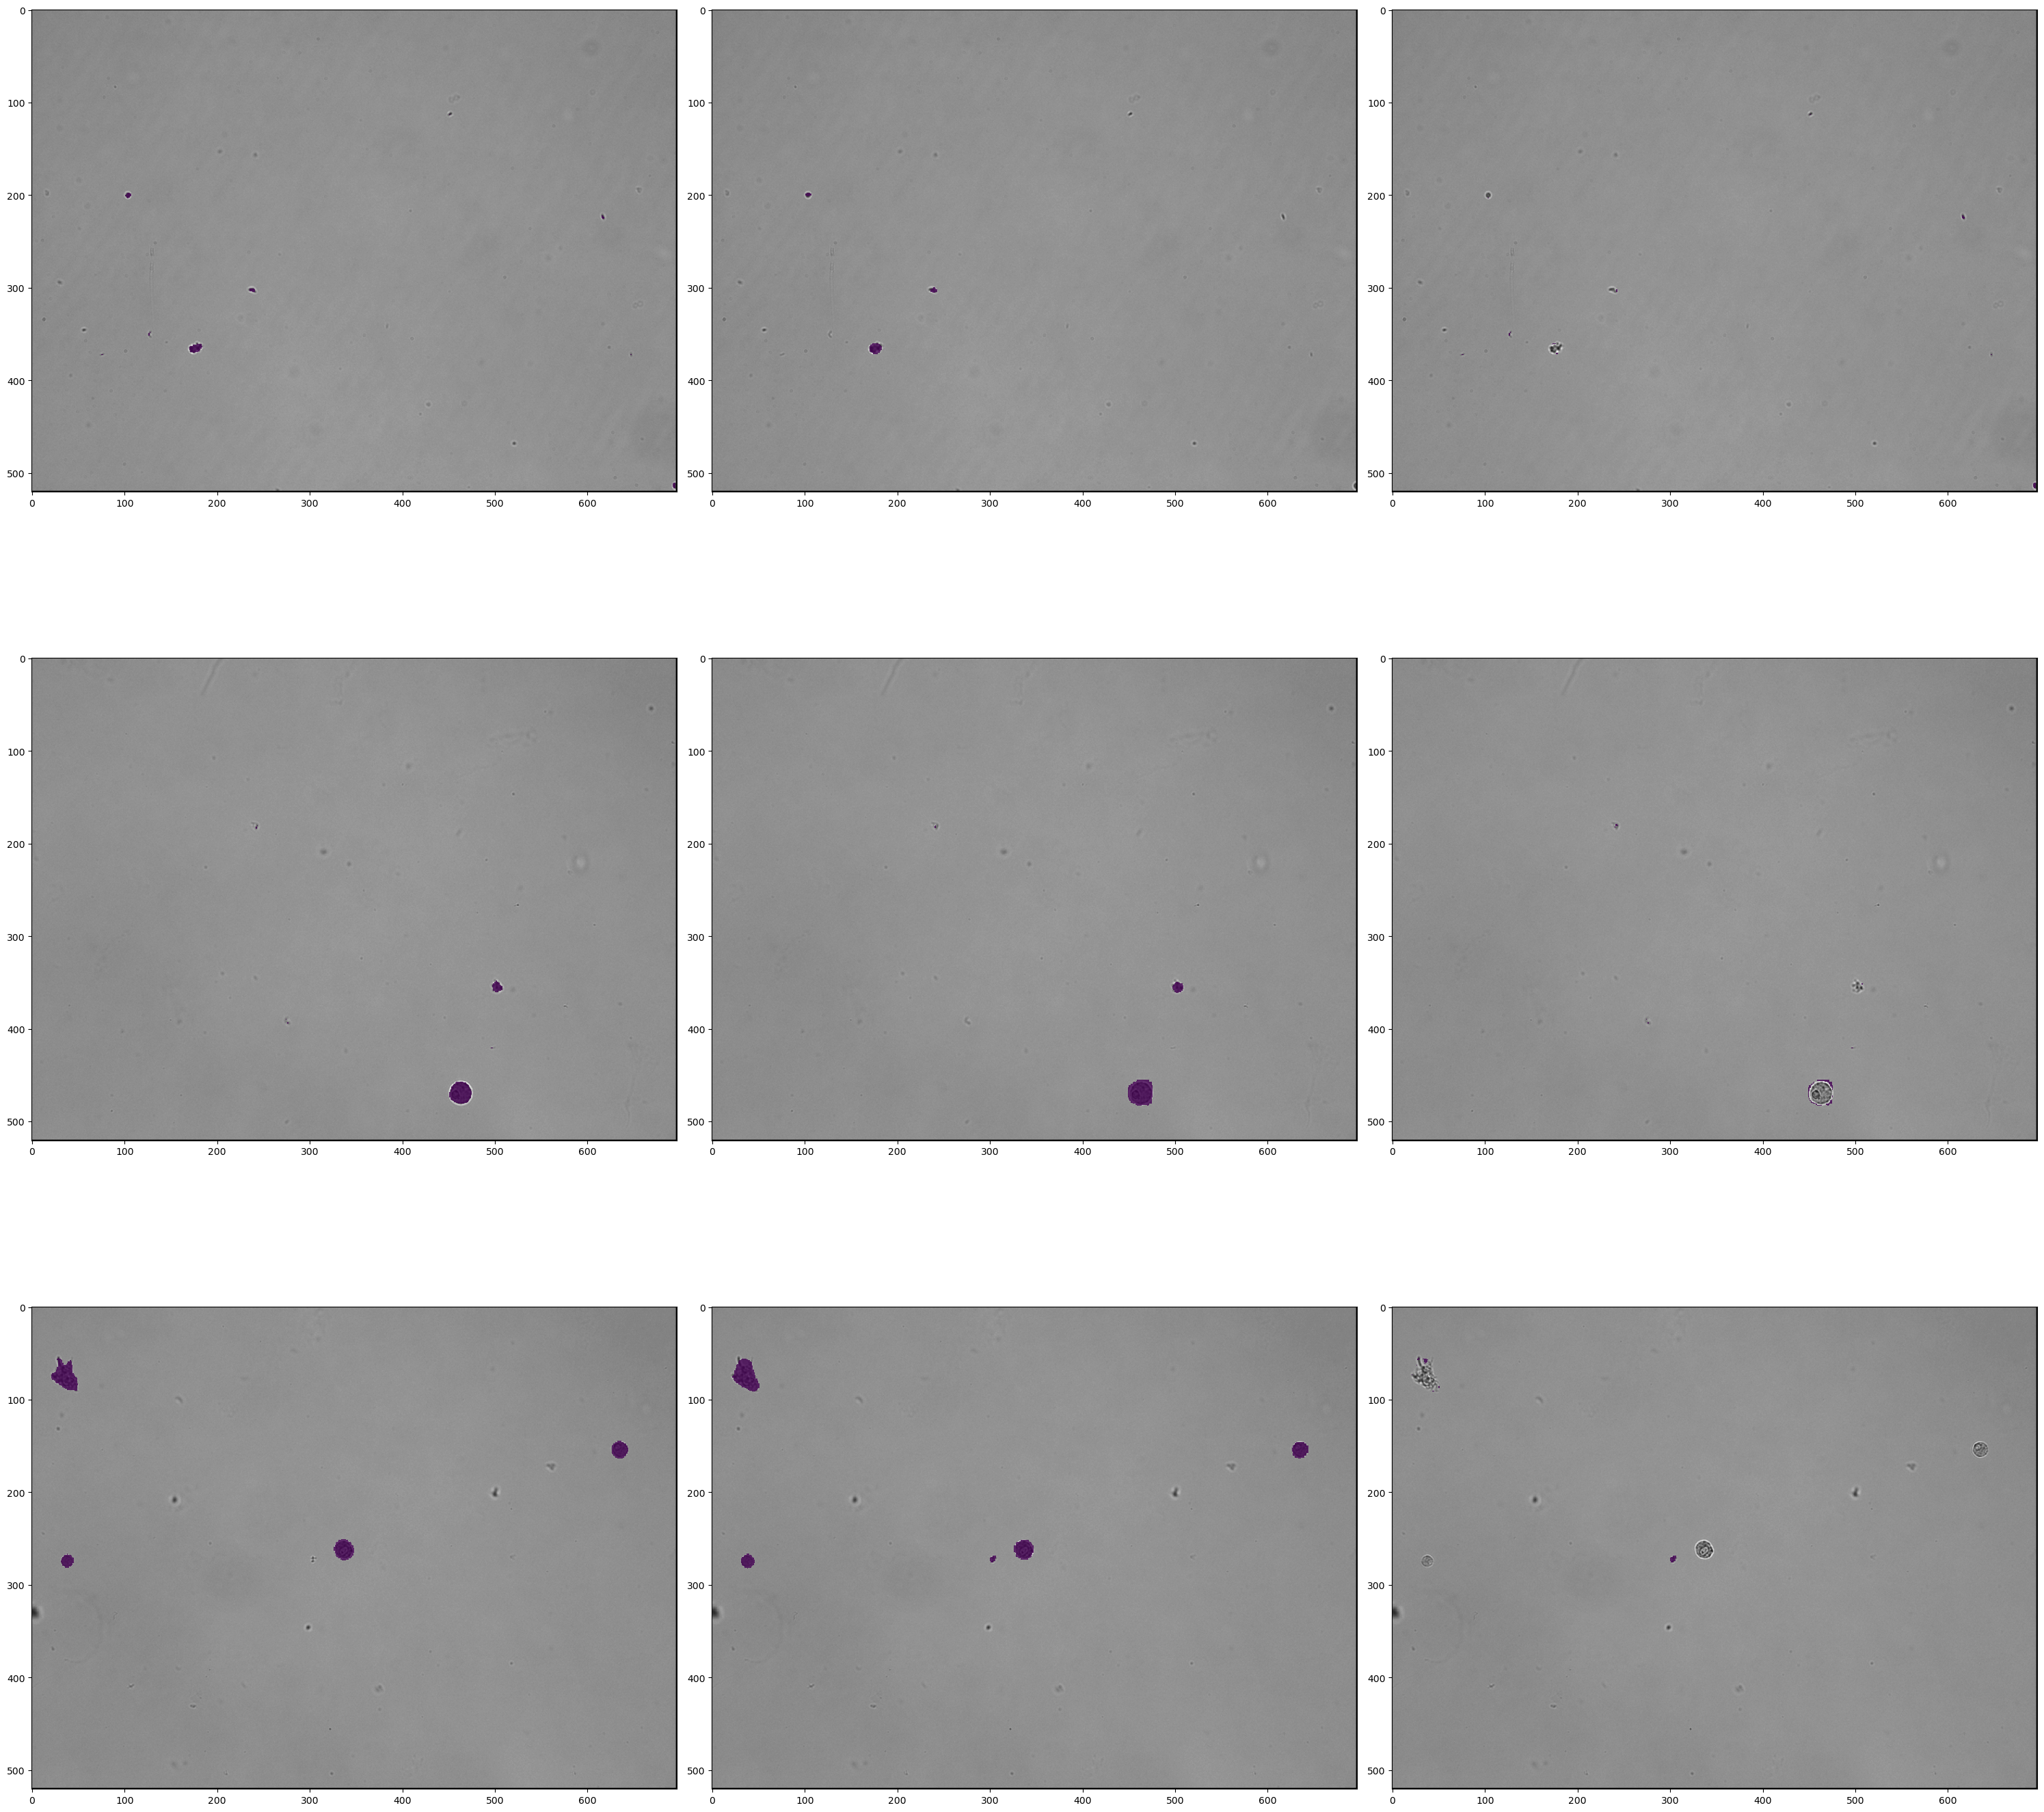

In [88]:
predict_and_plot(model, image_mask_dataset_val, np.arange(3))

In [90]:
dice = []

for img, mask in image_mask_dataset_val:
    img, mask = img[0], mask[0]
    pred = predict(model, [img])[0]
    dice.append(dice_coeff(mask, pred).numpy())

In [44]:
indices = np.argsort(dice)

In [45]:
indices

array([20, 25, 22, 96, 61, 98, 63, 60,  5, 41, 86,  0, 97, 17, 87,  6, 37,
       42, 66, 89, 90, 53, 75, 67, 36, 34, 21, 68, 76,  1, 58, 55, 33, 14,
       81,  9, 29, 28, 77, 38, 82, 92, 24, 57, 27, 12, 70, 43, 73, 74, 48,
       59, 71,  8, 85, 23, 10, 47, 65, 88, 56, 49, 13, 46, 62, 69, 91, 11,
       84, 51,  2, 93, 18, 54, 79, 45, 16, 80,  3, 64, 31, 94,  4, 35, 44,
       30, 15, 19, 50, 95, 32, 39, 26,  7, 72, 52, 83, 99, 78, 40])

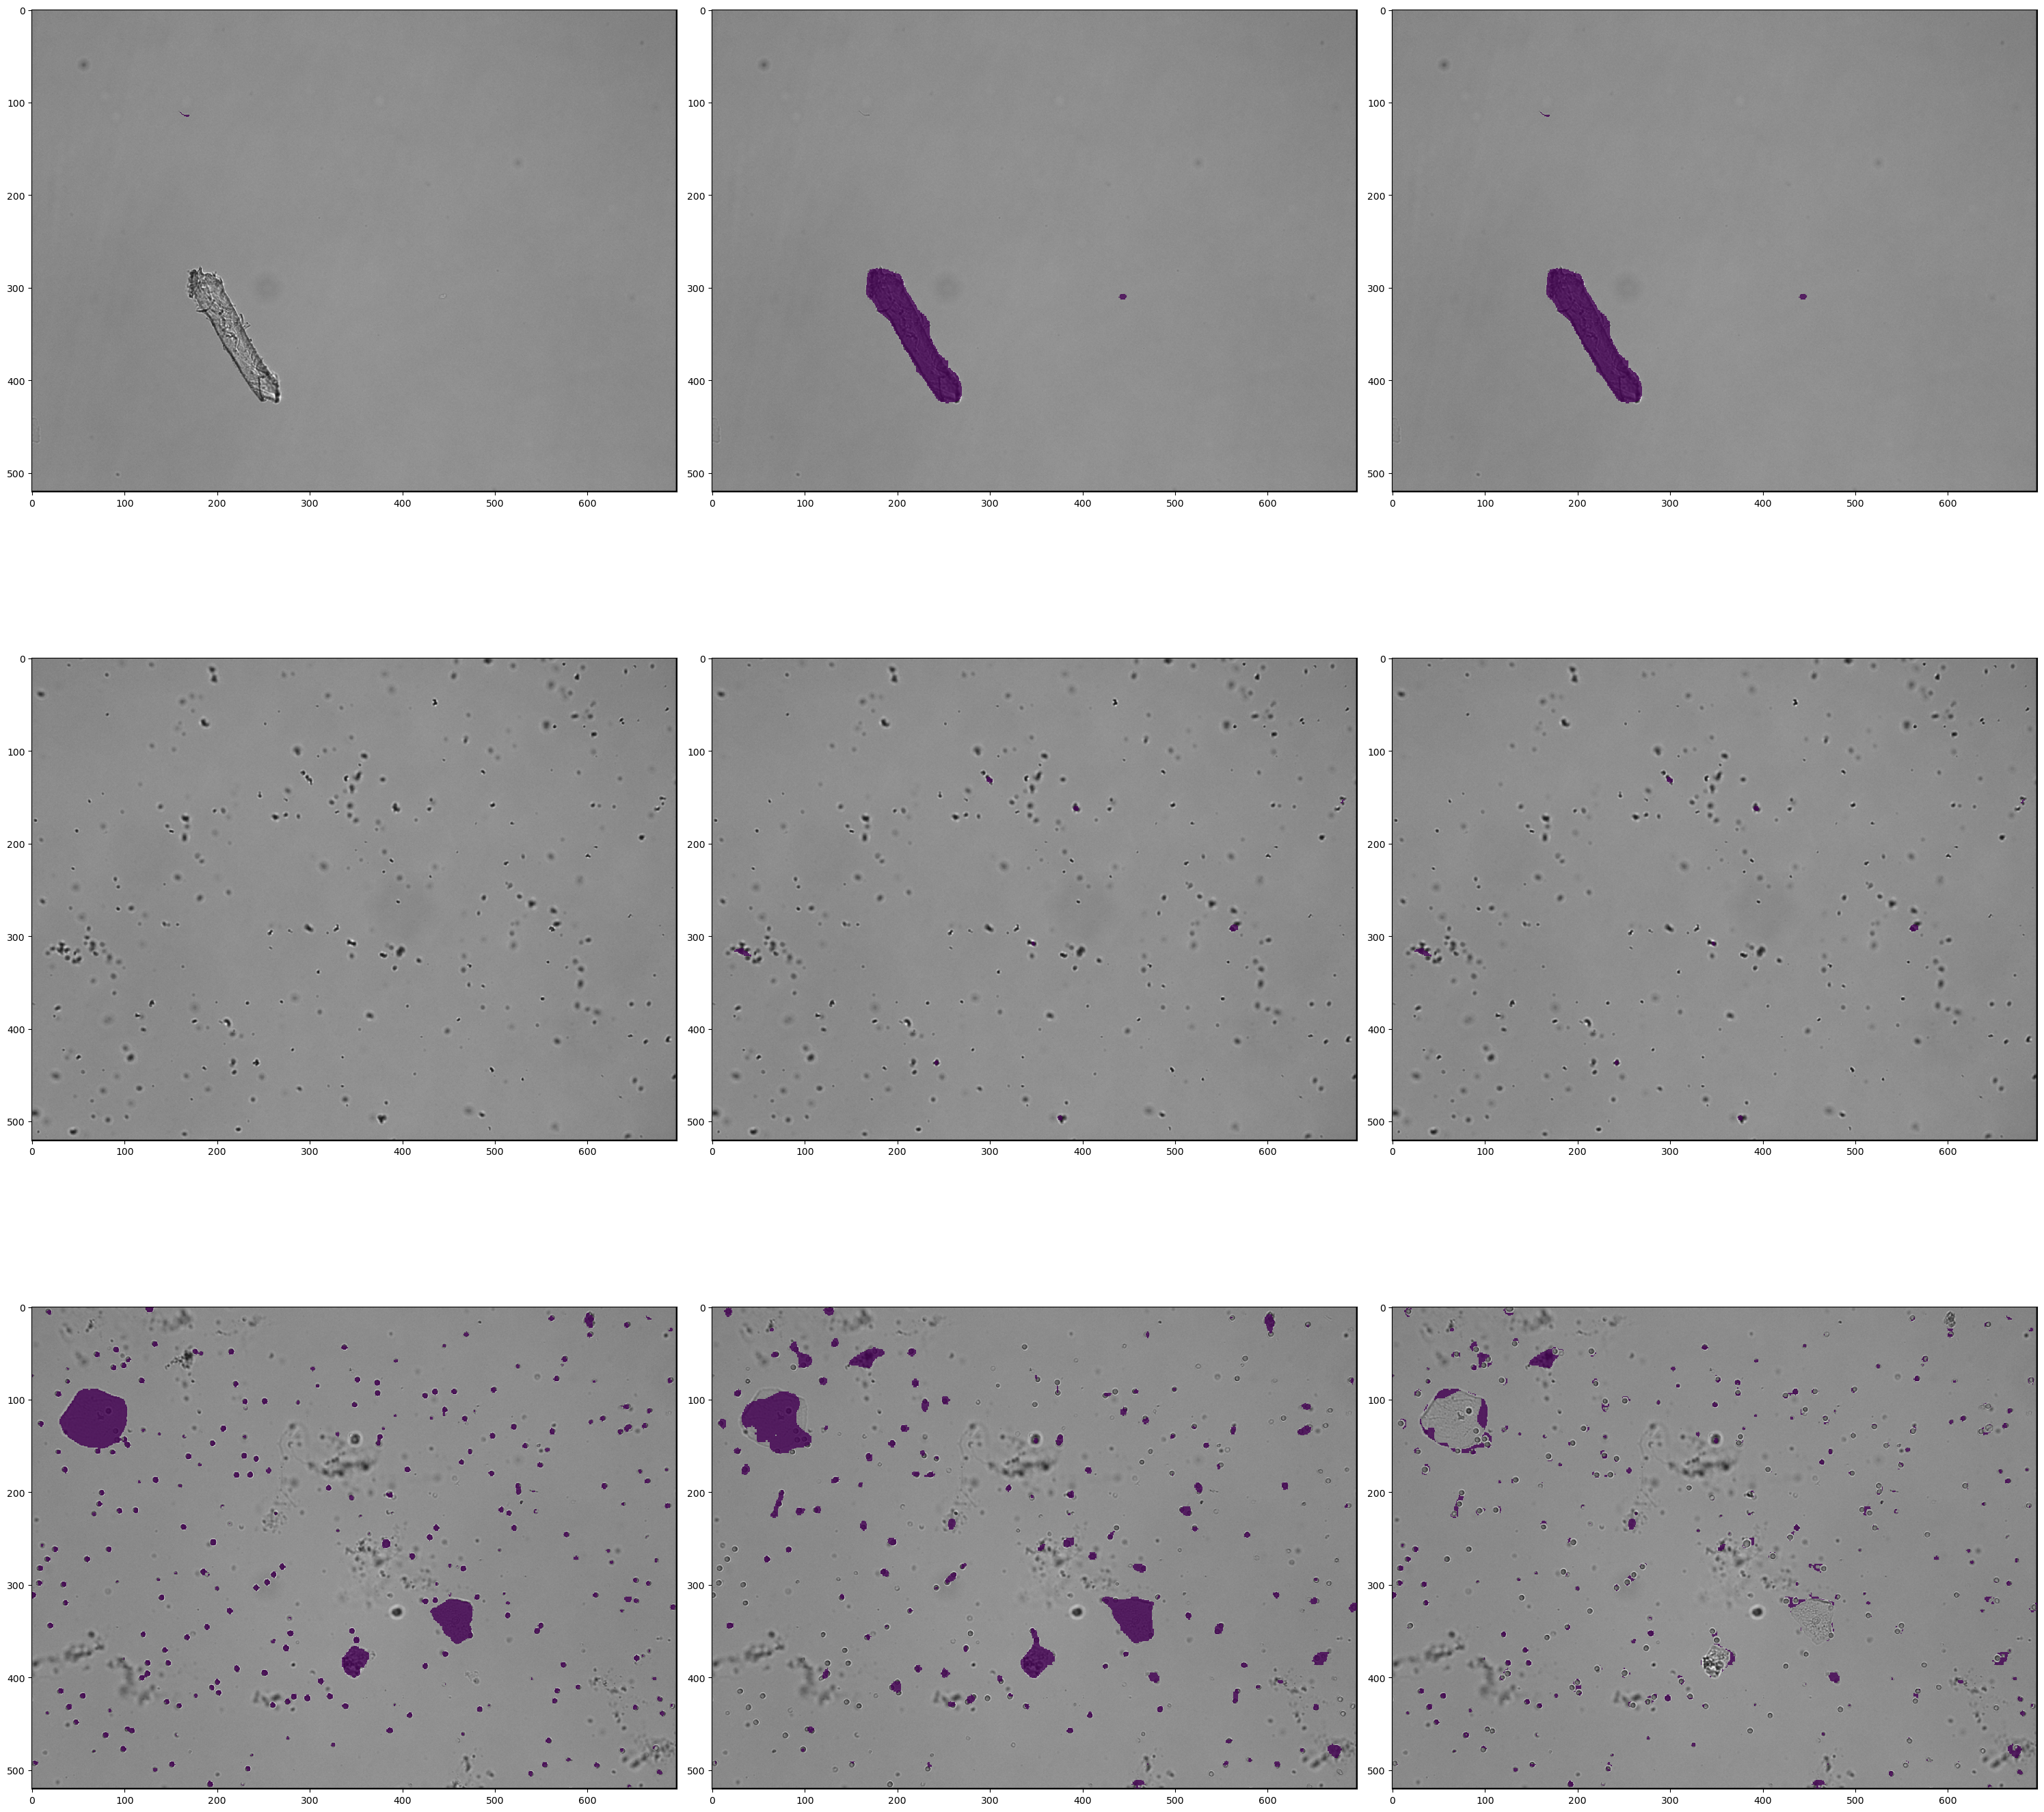

In [96]:
fig = predict_and_plot(model, image_mask_dataset_val, indices[[0, 1, 9]])
fig.savefig(figures_dir / "bad_predictions.svg", dpi=300)

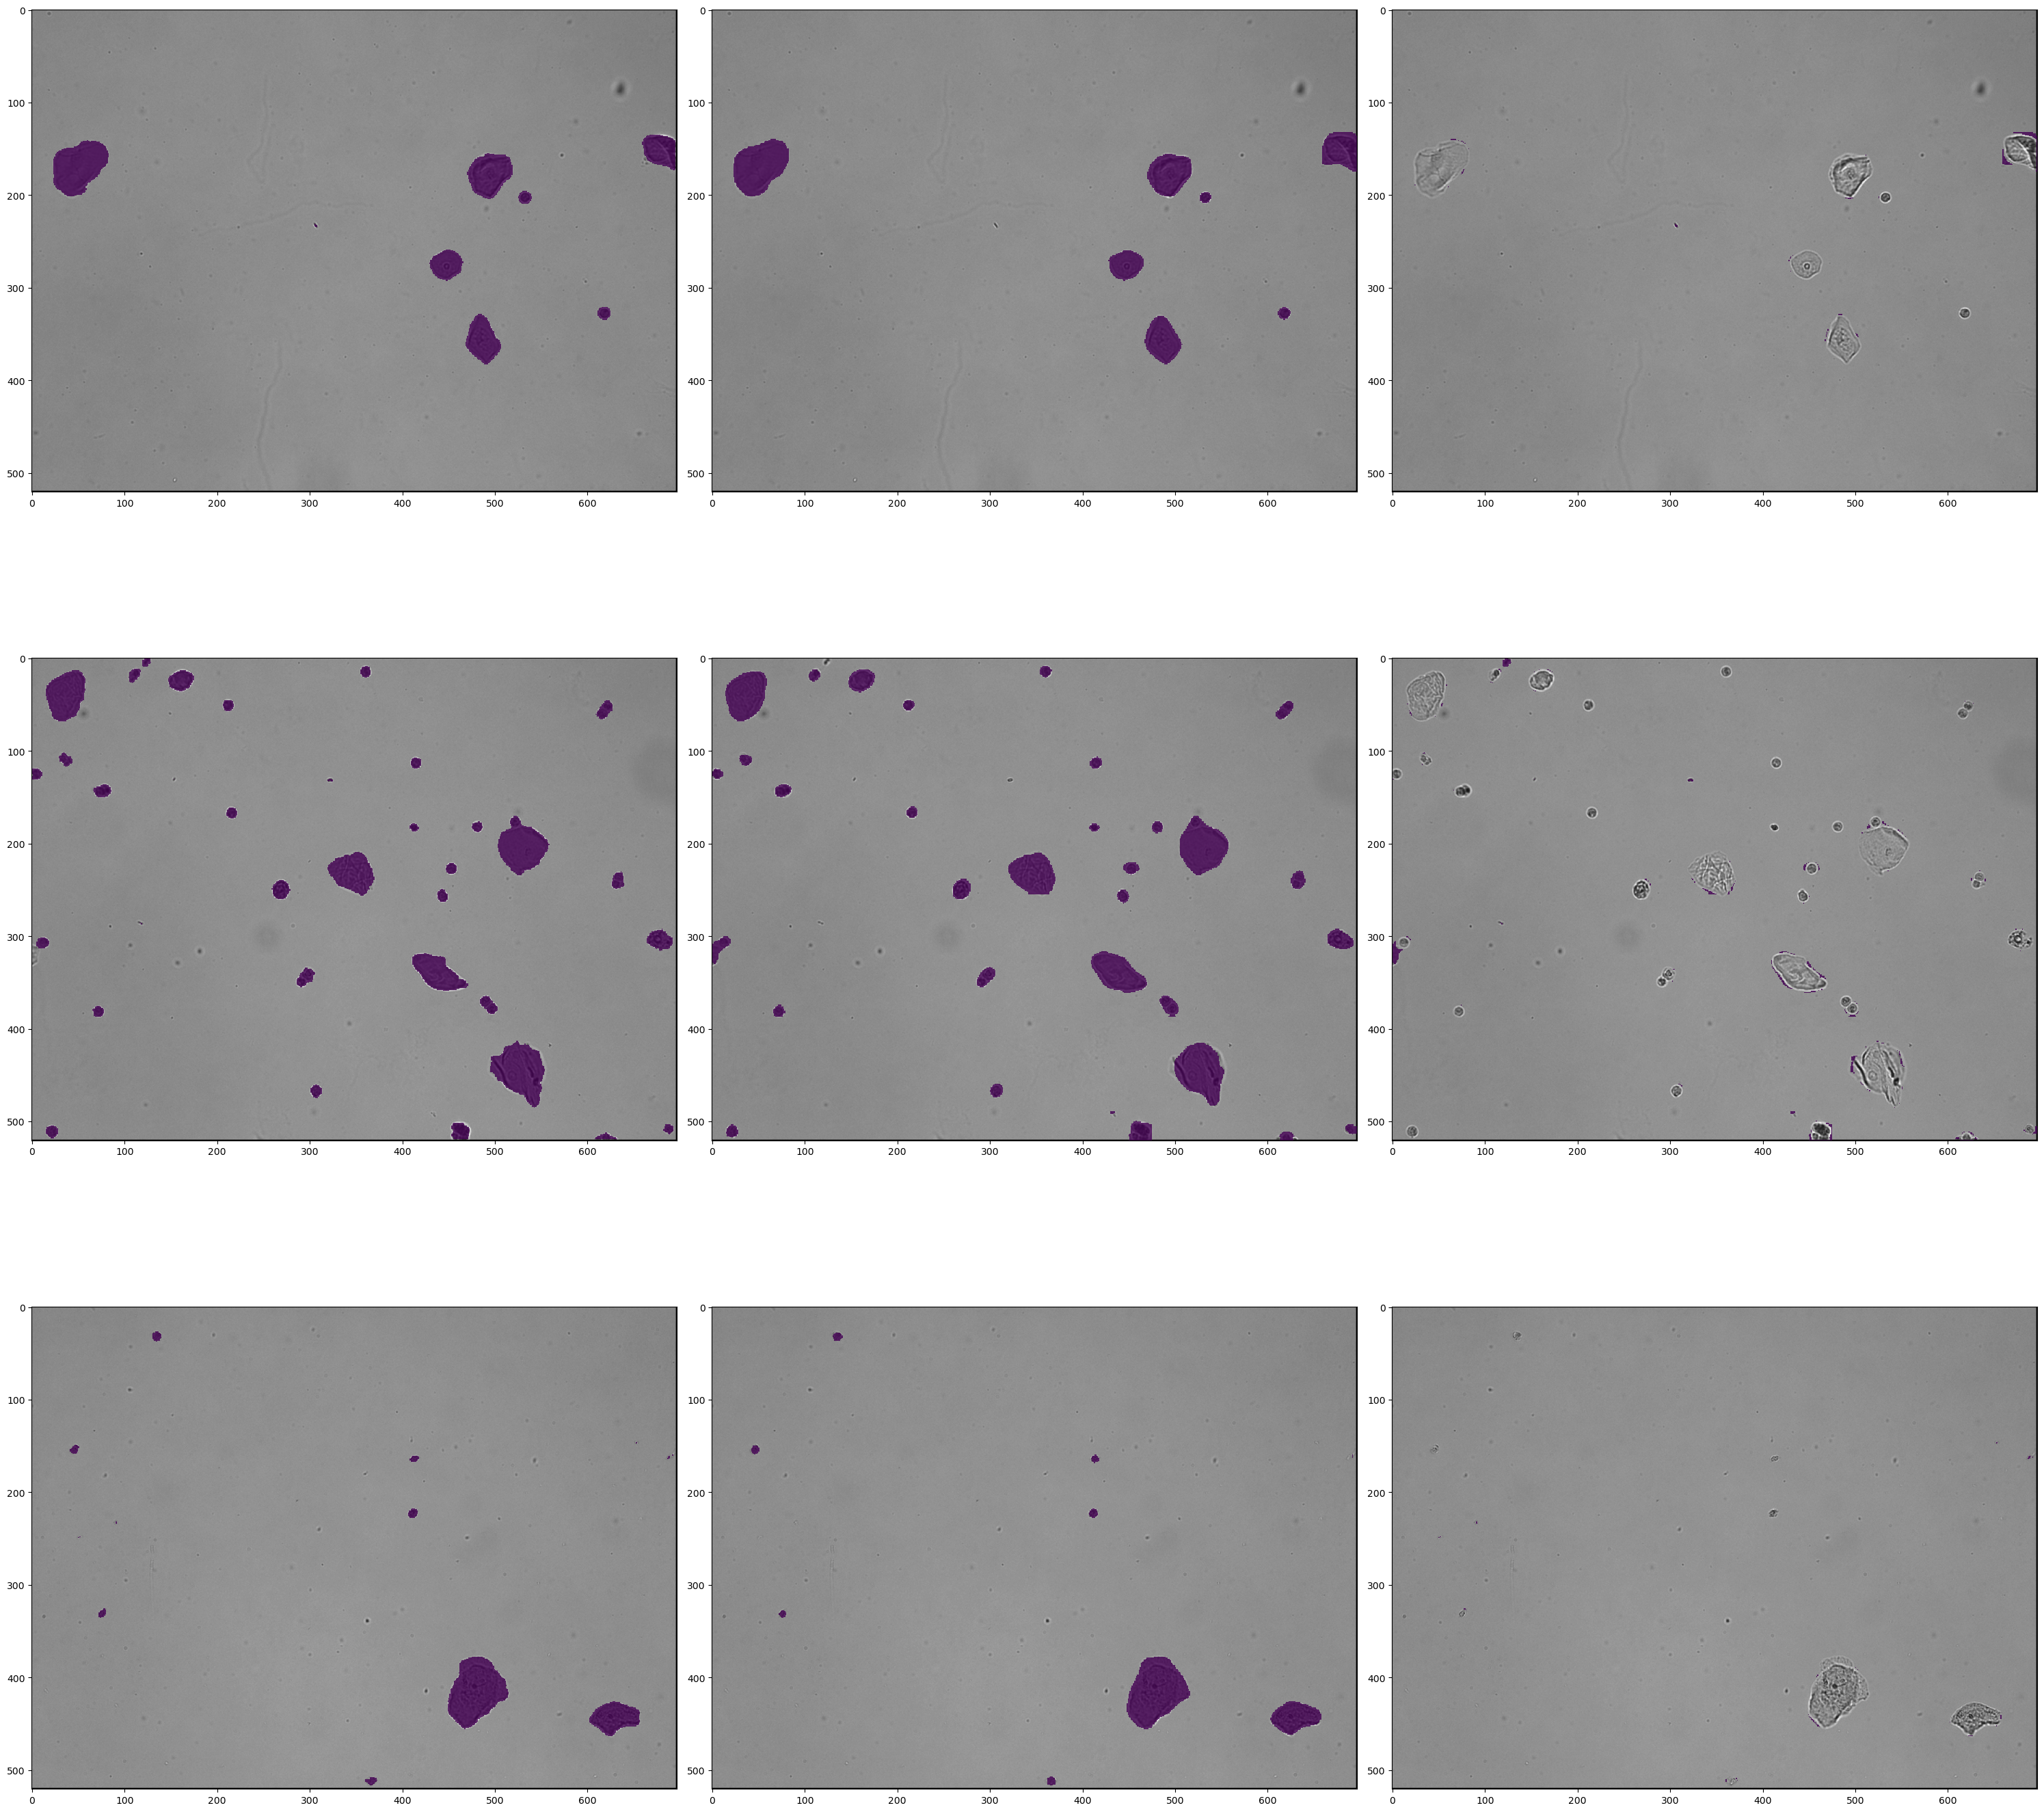

In [98]:
fig = predict_and_plot(model, image_mask_dataset_val, indices[[-9, -29, -7]])
fig.savefig(figures_dir / "good_predictions.svg", dpi=300)

In [100]:
idx = indices[-29]
img, _ = image_mask_dataset_val[idx]
img = img[0]

In [101]:
patches, breakpoints = split_into_patches(img, 256, 256)

cmap = cm.Set3

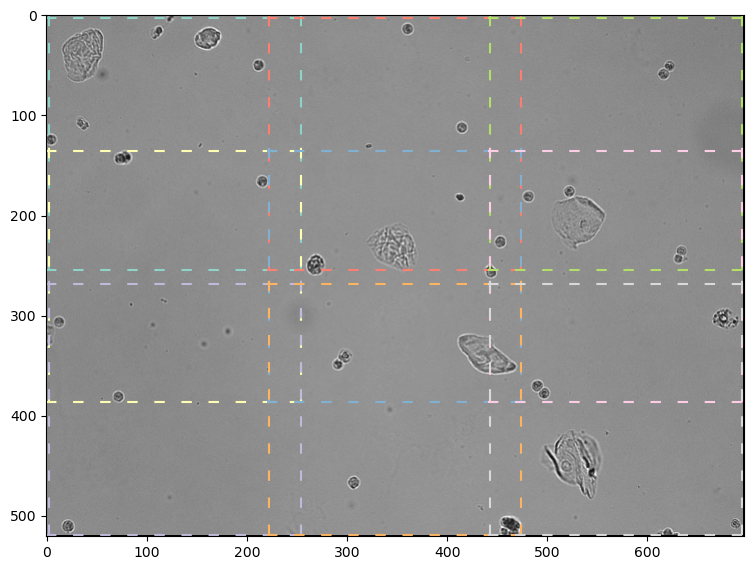

In [219]:
max_y, max_x, _ = img.shape
plt.figure(figsize=(9,9))
plt.imshow(img, cmap='gray')
for color, (y, x) in enumerate(breakpoints):
    kwargs = {
        "linestyle": (0, (5, 8)),
        "alpha": 1,
        "linewidth": 1.5,
    }
    plt.axvline(x+2, (max_y-y-255)/max_y, (max_y-y)/max_y, c=cmap(color), **kwargs)
    plt.axvline(x+254, (max_y-y-255)/max_y, (max_y-y)/max_y, c=cmap(color), **kwargs)
    plt.axhline(y+3, x/max_x, (x+255)/max_x, c=(cmap(color)), **kwargs)
    plt.axhline(y+254, x/max_x, (x+255)/max_x, c=(cmap(color)), **kwargs)
plt.savefig(figures_dir / "splitting_masks" / "original.svg", dpi=300)

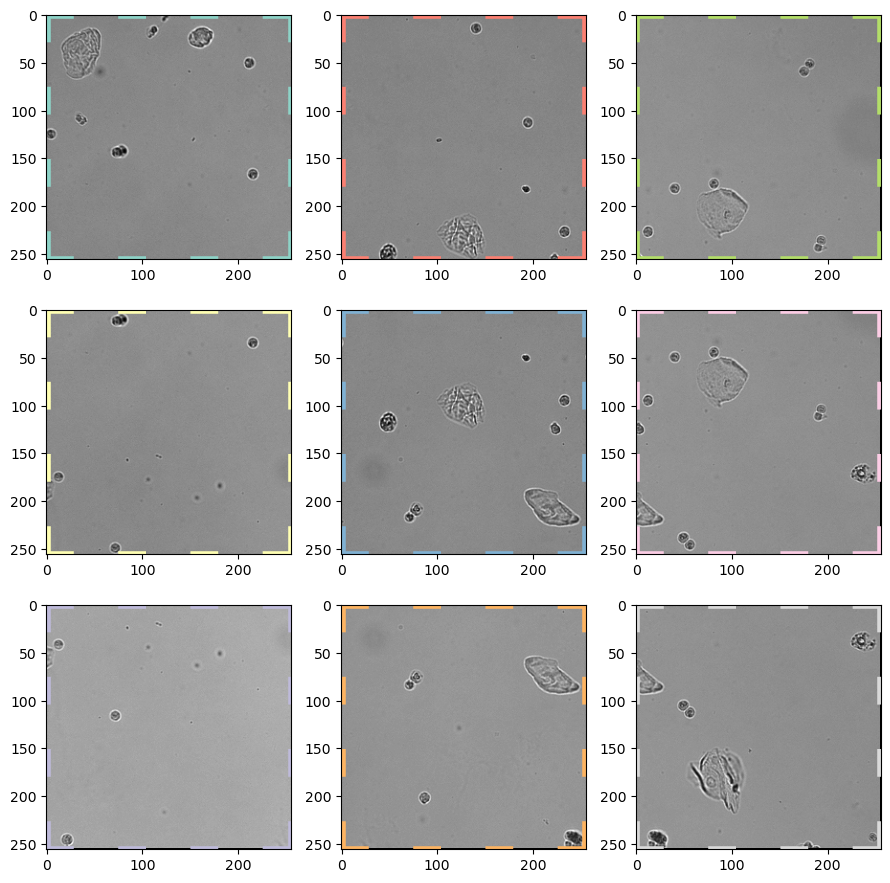

In [220]:
fig, axes = plt.subplots(3, 3, figsize=(9, 9))
kwargs = {
    "linestyle": (0, (5, 8)),
    "alpha": 1,
    "linewidth": 4,
}
for idx in range(9):
    axes[idx%3, idx//3].imshow(patches[idx], cmap='gray')
    axes[idx%3, idx//3].axvline(1, c=cmap(idx), **kwargs)
    axes[idx%3, idx//3].axvline(255, c=cmap(idx), **kwargs)
    axes[idx%3, idx//3].axhline(1, c=(cmap(idx)), **kwargs)
    axes[idx%3, idx//3].axhline(255, c=(cmap(idx)), **kwargs)
plt.tight_layout()
fig.savefig(figures_dir / "splitting_masks" / "original_patches.svg", dpi=300)

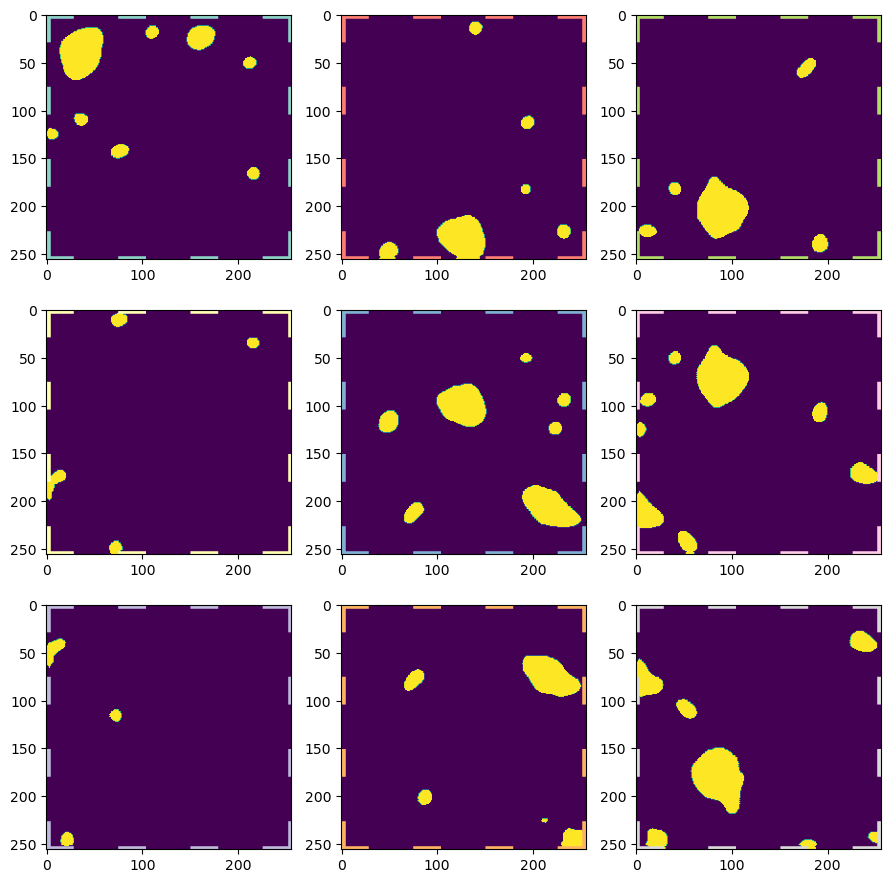

In [221]:
preds = model(patches)
preds = np.rint(preds).astype(np.float32)
fig, axes = plt.subplots(3, 3, figsize=(9, 9))
kwargs = {
    "linestyle": (0, (5, 8)),
    "alpha": 1,
    "linewidth": 4,
}
for idx in range(9):
    axes[idx%3, idx//3].imshow(preds[idx])
    axes[idx%3, idx//3].axvline(1, c=cmap(idx), **kwargs)
    axes[idx%3, idx//3].axvline(255, c=cmap(idx), **kwargs)
    axes[idx%3, idx//3].axhline(1, c=(cmap(idx)), **kwargs)
    axes[idx%3, idx//3].axhline(255, c=(cmap(idx)), **kwargs)
plt.tight_layout()
fig.savefig(figures_dir / "splitting_masks" / "pred_patches.svg", dpi=300)

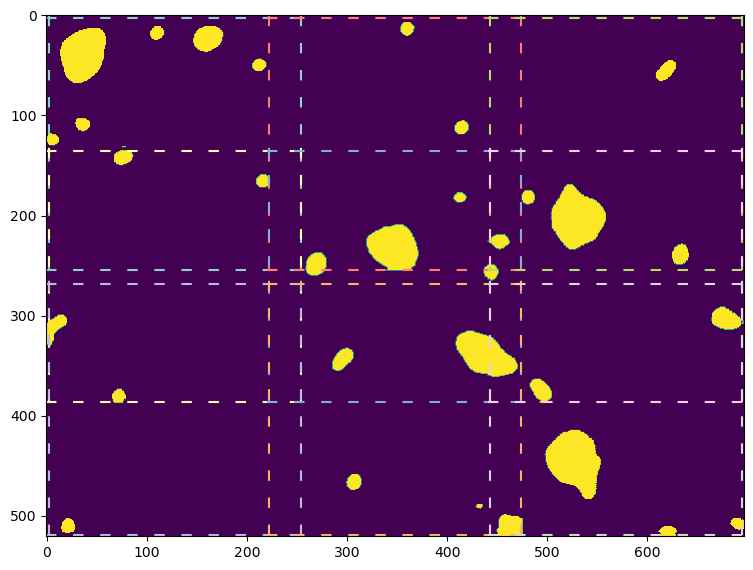

In [222]:
pred = combine_patches(preds, breakpoints)
max_y, max_x, _ = pred.shape
plt.figure(figsize=(9, 9))
plt.imshow(pred)
for color, (y, x) in enumerate(breakpoints):
    kwargs = {
        "linestyle": (0, (5, 8)),
        "alpha": 1,
        "linewidth": 1.5,
    }
    plt.axvline(x+2, (max_y-y-255)/max_y, (max_y-y)/max_y, c=cmap(color), **kwargs)
    plt.axvline(x+254, (max_y-y-255)/max_y, (max_y-y)/max_y, c=cmap(color), **kwargs)
    plt.axhline(y+3, x/max_x, (x+255)/max_x, c=(cmap(color)), **kwargs)
    plt.axhline(y+254, x/max_x, (x+255)/max_x, c=(cmap(color)), **kwargs)
plt.savefig(figures_dir / "splitting_masks" / "pred.svg", dpi=300)

In [68]:
def plot_data(dataset, index):
    img, mask = dataset[index]
    img, mask = img[0], mask[0]
    
    mask = np.ma.masked_where(mask == 0, mask)

    fig = plt.figure(figsize=(20, 20))
    plt.imshow(img, cmap='gray')
    plt.imshow(mask, alpha=0.8)
    plt.tight_layout()
    return fig

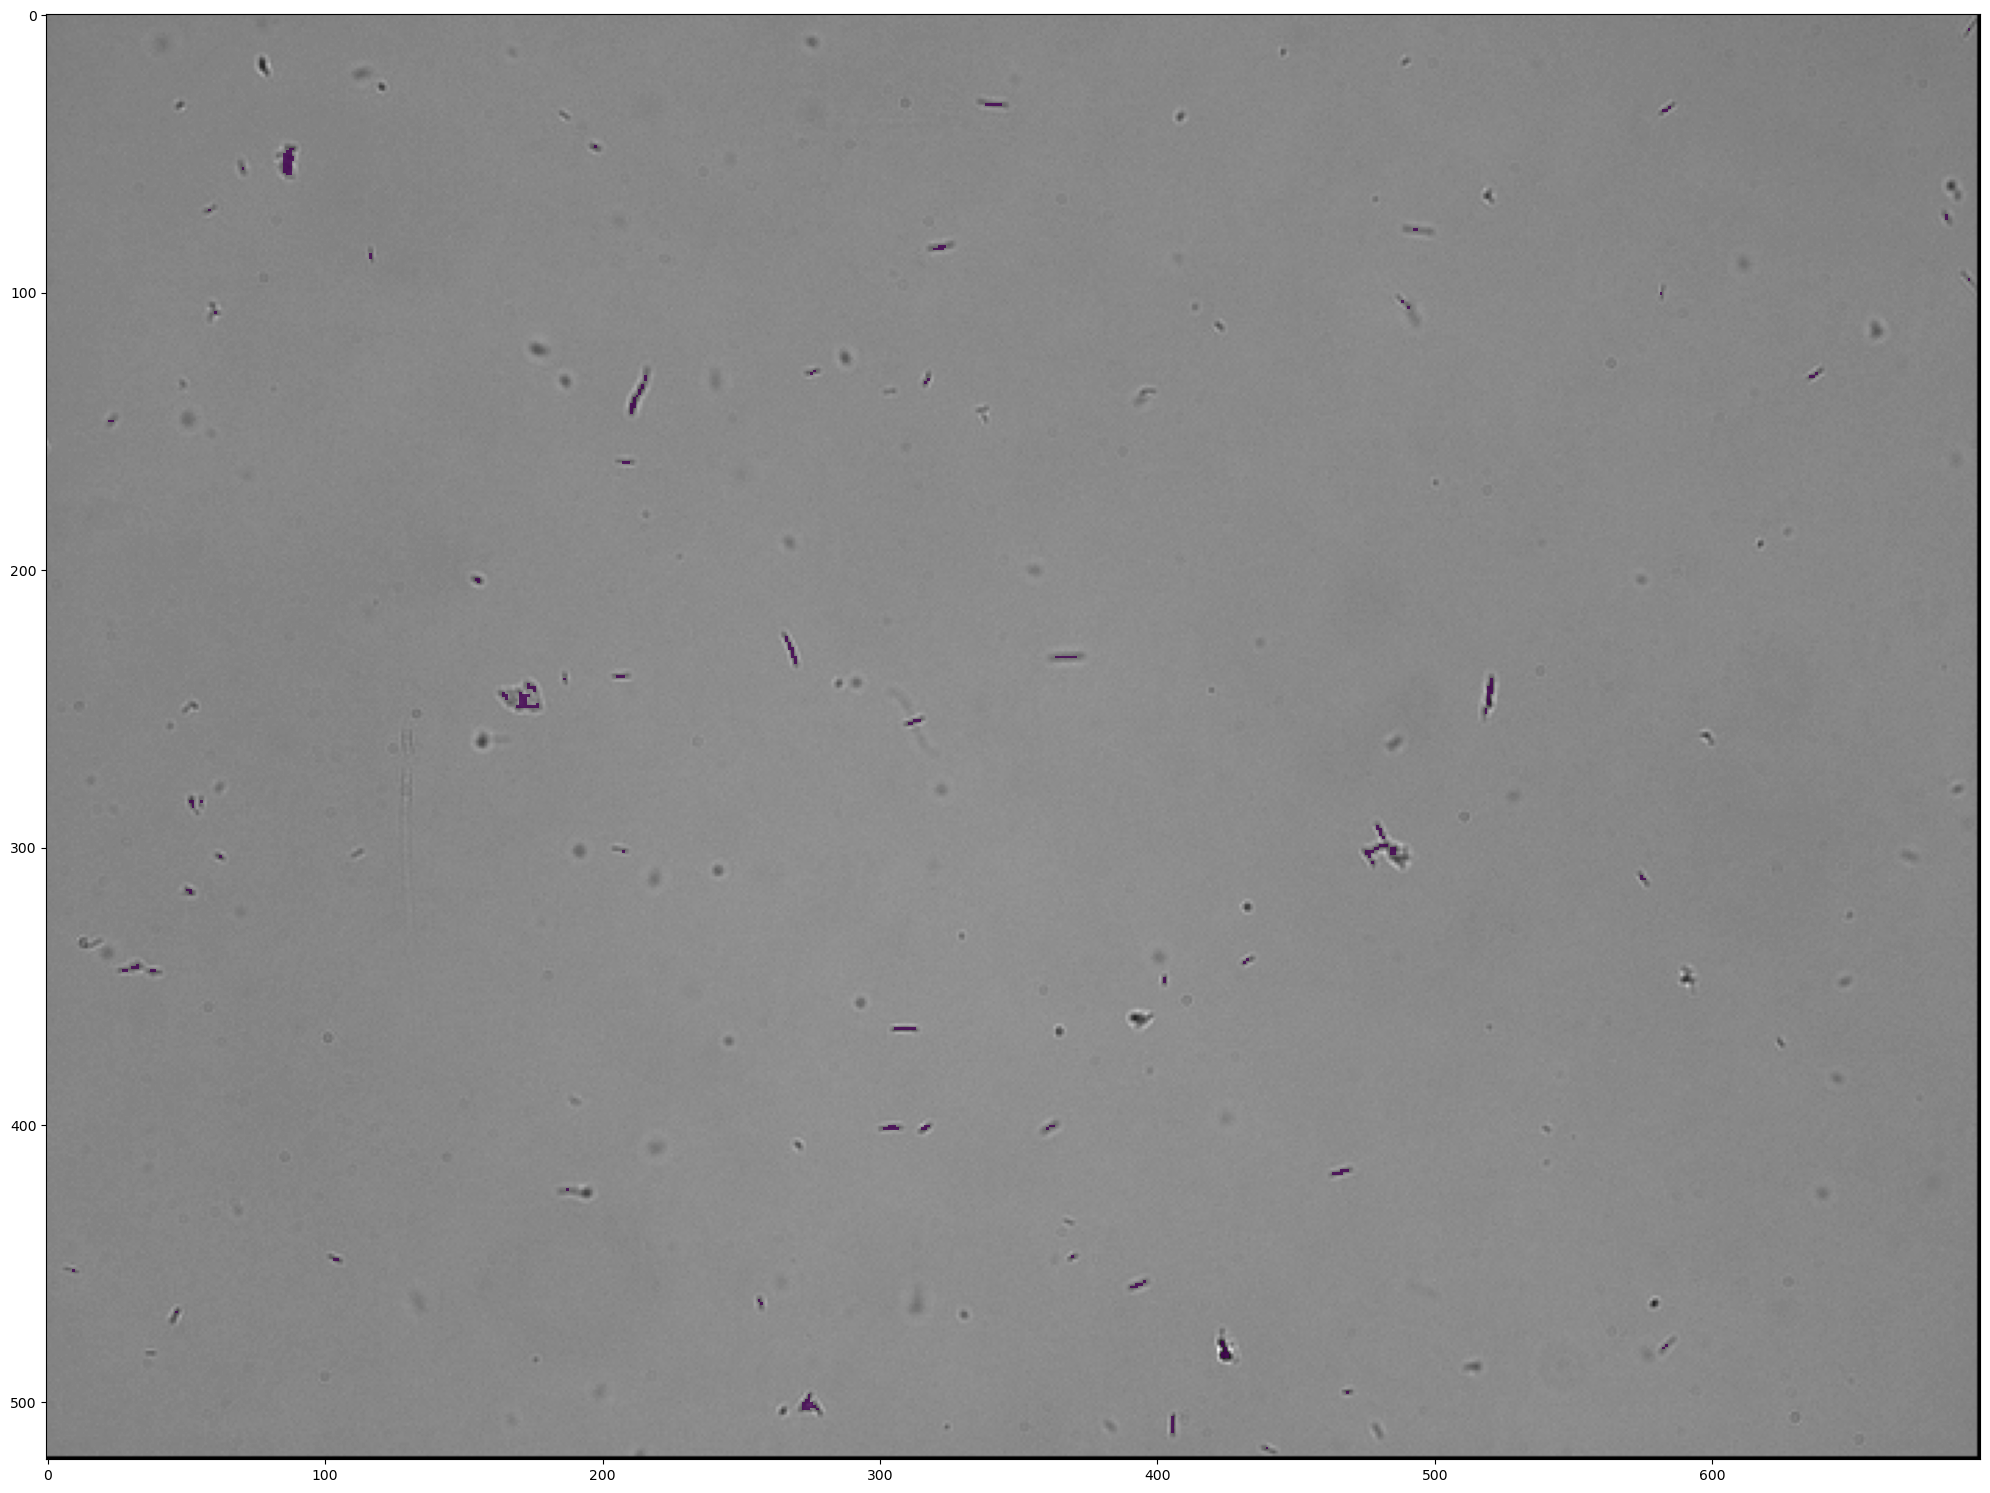

In [80]:
idx = 5
fig = plot_data(image_mask_dataset_val, indices[idx])

In [81]:
name = image_mask_dataset_val.img_names[indices[idx]].split('.')[0]
fig.savefig(figures_dir / "partial_masks" / f"{name}.svg", dpi=300)